In [1]:
from utils.binaries import *
from utils.plotting import *
import uproot

07:27:51 ( +107.2s) [INFO   ] -- import logging
07:27:51 (  +121ms) [INFO   ] -- import numpy as np
07:27:51 (    +9ms) [INFO   ] -- import uncertainties
07:27:51 (  +252ms) [INFO   ] -- import pandas as pd
07:27:51 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
07:27:51 (    +2ms) [INFO   ] -- import binaries.tools as tools
07:27:52 (  +317ms) [INFO   ] -- import matplotlib.pyplot as plt
07:27:52 (  +363ms) [INFO   ] -- import seaborn as so
07:27:52 (    +6ms) [DEBUG  ] -- font size set to 9.5
07:27:52 (    +1ms) [DEBUG  ] -- label size set to 13.0
07:27:52 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
07:27:52 (    +1ms) [DEBUG  ] -- markersize set to 2.0
07:27:52 (    +0ms) [DEBUG  ] -- usetex set to False
07:27:52 (    +3ms) [INFO   ] -- import plotting.tools as plot


In [2]:
def get_start_stop_variance(path):
    file = uproot.open(f'{path}:AugerUpTime')
    variances = np.array(file['ADCVariance'].array(), dtype=float)[:,-3:,:]
    shutter_open_fraction = np.array(file['ShutterFraction8ADC'].array())[:,-3:]
    variances *= shutter_open_fraction[:, :, np.newaxis]

    indices = [i for i, var in enumerate(variances) if np.sum(var) != 0]
    # indices = [i for i, var in enumerate(variances) if np.all(np.logical_and(var.mean(axis=1)>0, var.mean(axis=1)<200))]
    start, stop = file['uptime_gpsStart'].array(), file['uptime_gpsStop'].array()
    return start[indices], stop[indices], variances[indices]

def get_calibration_constant(date, method):

    results = '/cr/data01/filip/xy-calibration/results/'

    # force preclean usage
    # date = '2023-07'

    # force postclean usage
    date = '2023-11'

    if date < '2023-11':        # before mirror cleaning
        # print('before MC')
        heat1_run = '6020x'
        heat2_run = '6025'
        heat3_run = '6031x'

    else:                       # after mirror cleaning
        # print('after MC')
        heat1_run = '6070'
        heat2_run = '6075'
        heat3_run = '6066'

    heat1 = pd.read_csv(f'{results}/outCorr_{heat1_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat2 = pd.read_csv(f'{results}/outCorr_{heat2_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    heat3 = pd.read_csv(f'{results}/outCorr_{heat3_run}.txt', skiprows=5, index_col=0, delimiter=' ',
                        names=['pixel', 'calibConst', 'adcSum', 'stdCalib', 'calibConstCorr'])
    
    match method.lower():
        case 'xy':
            calibration_constants = heat1.calibConstCorr.values, heat2.calibConstCorr.values, heat3.calibConstCorr.values
        case 'cala':
            calibration_constants = heat1.stdCalib.values, heat2.stdCalib.values, heat3.stdCalib.values
        case _:
            calibration_constants = np.ones((3, 440))

    return calibration_constants

/tmp/ipykernel_2919752/3979065580.py:84: RuntimeWarning: Mean of empty slice
  means = [np.nanmean(var[:, i,:], axis=0) for i in range(3)]
/tmp/ipykernel_2919752/3979065580.py:97: RuntimeWarning: Mean of empty slice
  heat1, heat2, heat3 = np.nanmean(means, axis=1)
/tmp/ipykernel_2919752/3979065580.py:106: RuntimeWarning: Mean of empty slice
  ax2.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle = {np.nanmean(means[1]):.2f}$', transform=ax2.transAxes, **text_kwargs)


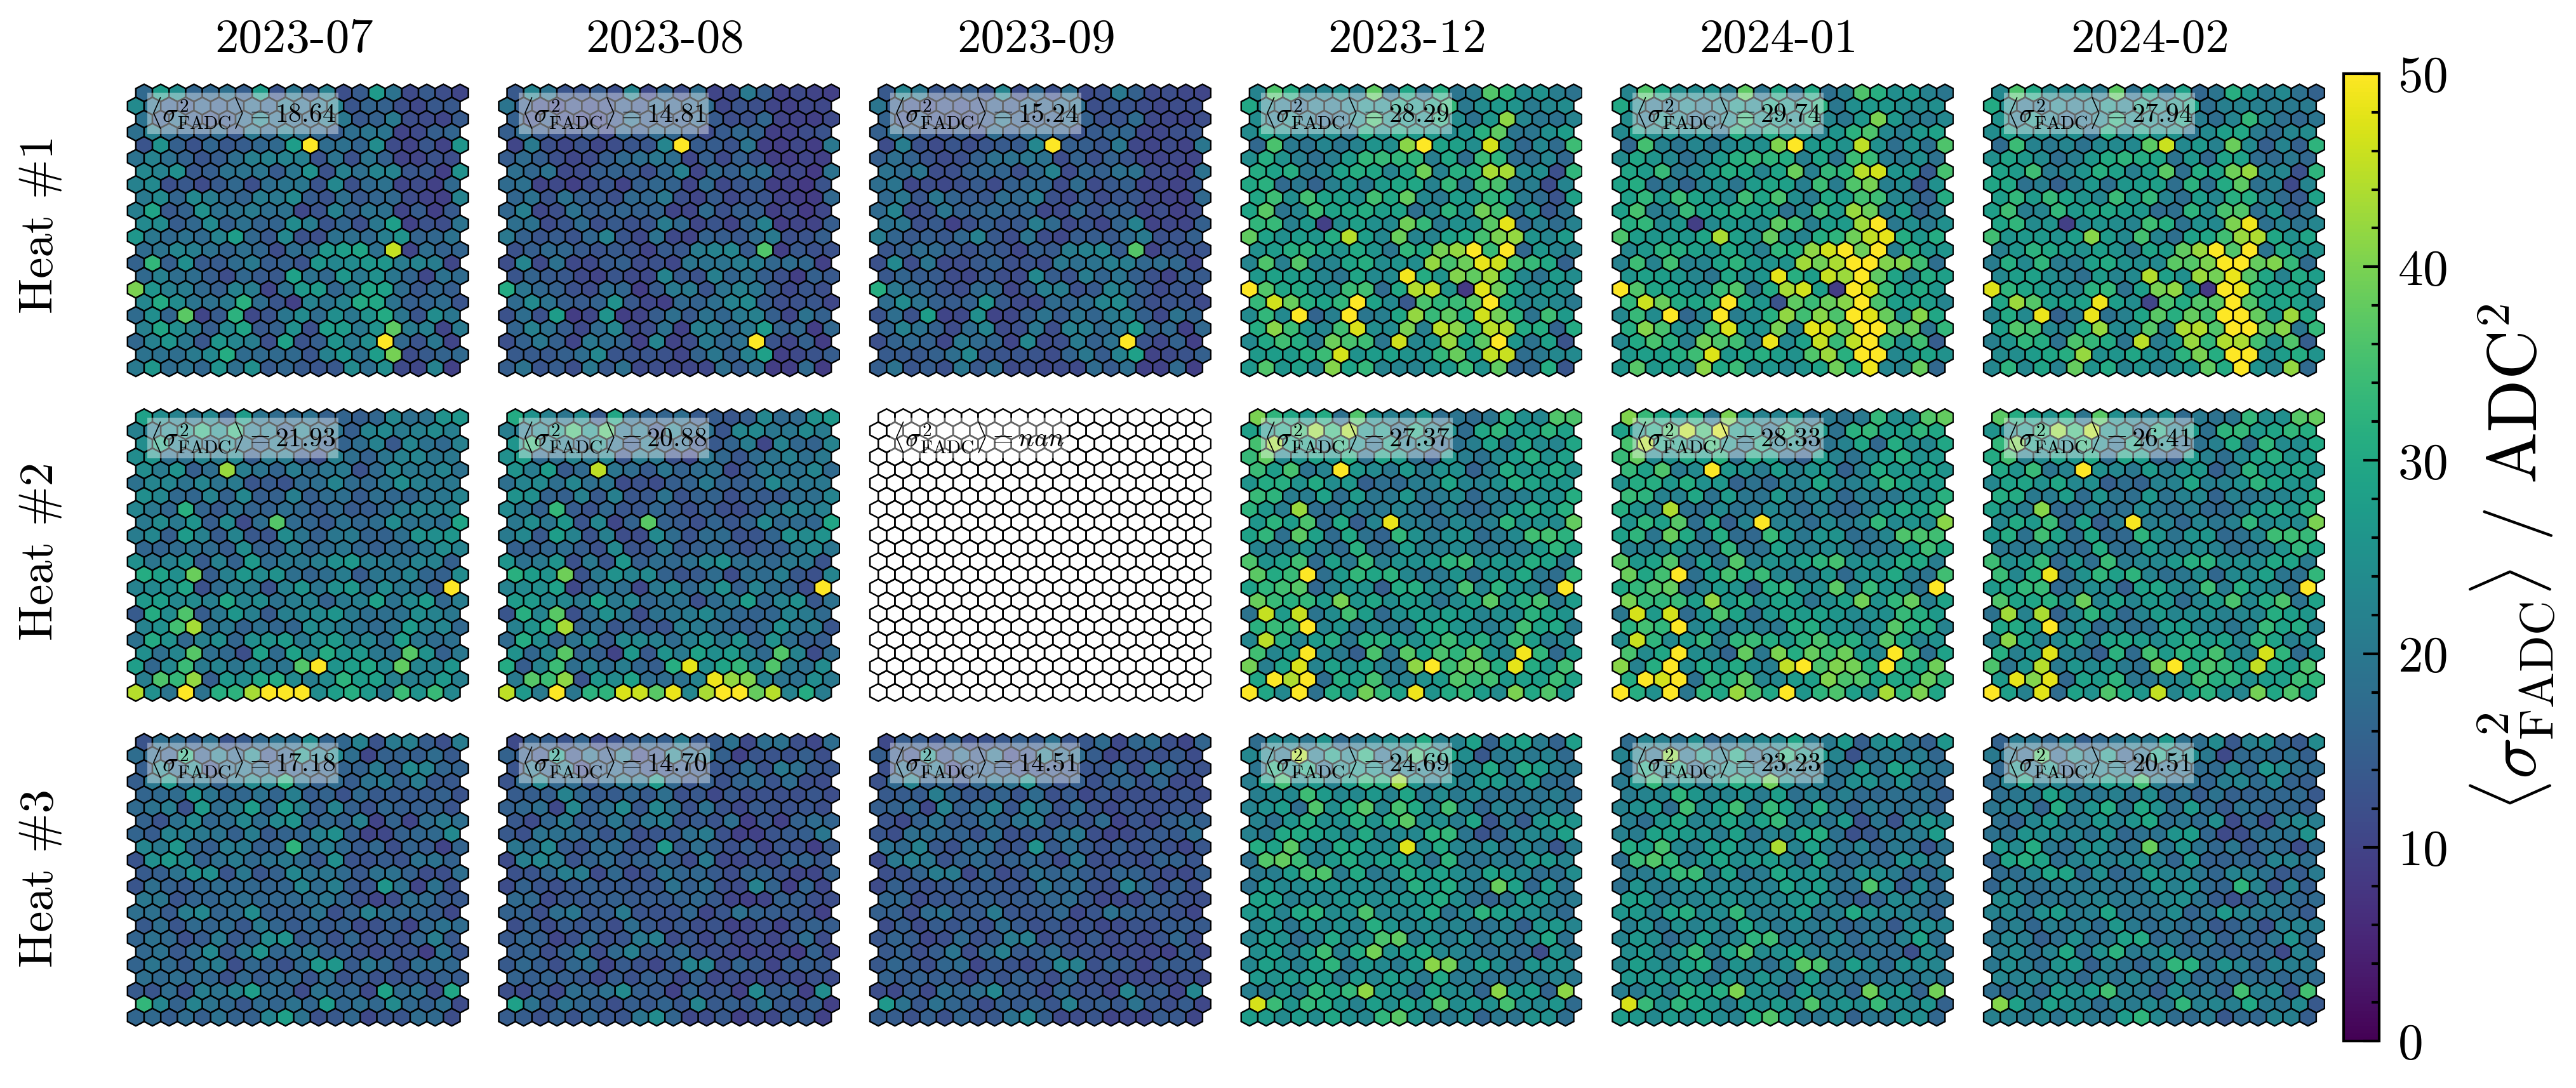

In [11]:
from datetime import datetime
from utils.Auger.FD import PixelPlot
from matplotlib.gridspec import GridSpec

files = [#'2022-10-01-12utc.root',
        #  '2023-03-01-12utc.root',
        #  '2023-04-01-12utc.root',
        #  '2023-05-01-12utc.root',
        #  '2023-06-01-12utc.root',
         '2023-07-01-12utc.root', 
         '2023-08-01-12utc.root', 
         '2023-09-01-12utc.root', 
        #  '2023-10-01-12utc.root', 
        #  '2023-11-01-12utc.root', 
         '2023-12-01-12utc.root',
         '2024-01-01-12utc.root',
         '2024-02-01-12utc.root'
         ]

# fig1, laxes = plt.subplots(len(files), 1, sharey=True)
# fig1.text(.02, 0.5, 'Variance / $\mathrm{ADC}^2$', rotation=90,
#          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 18})
# plt.subplots_adjust(hspace=0.6)

fig2 = plt.figure()
gs = GridSpec(
        3,
        len(files) + 1,
        figure=fig2,
        width_ratios=[1 for _ in files] + [0.1],
        height_ratios = [1/3, 1/3, 1/3],
    )
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.02)

fig2.text(.02, 0.76, 'Heat #1', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})
fig2.text(.02, 0.5, 'Heat #2', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})
fig2.text(.02, 0.24, 'Heat #3', rotation=90,
          fontdict={'ha' : 'center', 'va' : 'center', 'fontsize' : 9})

method = '_'
if method == '_':
    vmin, vmax = 0, 50
    name = 'raw_variance'
    unit = '$\mathrm{{ADC}}^2$'
    symbol = ''
elif method == 'cala':
    vmin, vmax = 30, 140
    name = 'CalA_normalized'
    symbol = 'K_\mathrm{D}'
    unit = r'$\mathrm{{ADC}}\times\mathrm{{photon}}$'
elif method == 'xy':
    vmin, vmax = 30, 140
    name = 'XY_normalized'
    symbol = 'K_\mathrm{XY}'
    unit = r'$\mathrm{{ADC}}\times\mathrm{{photon}}$'

means_before, means_after = [], []
font_dict = {'fontsize' : 5, 'ha' : 'left', 'va' : 'top',}
bbox_dict = {'boxstyle' : 'square', 'fc' : 'w', 'ec' : 'none', 'alpha' : 0.4, 'pad' : 0.1}
text_kwargs = {'c' : 'k', 'weight' : 'black', **font_dict, 'bbox' : bbox_dict}

for col, file in enumerate(files):

    start, stop, var = get_start_stop_variance(file)

    # skip = 35 if file == '2022-10-01-12utc.root' else 0
    # timestamps = [datetime.fromtimestamp(0.5*(e+b)) for e, b in zip(start, stop)]
    # lax.set_title(file[:7], pad=1, fontsize=6)
    # lax.set_xticklabels([])

    # lax.scatter(timestamps[skip:], np.mean(var[skip:,0,:], axis=1), label='Heat #1', s=0.1)
    # lax.scatter(timestamps[skip:], np.mean(var[skip:,1,:], axis=1), label='Heat #2', s=0.1, zorder=10)
    # lax.scatter(timestamps[skip:], np.mean(var[skip:,2,:], axis=1), label='Heat #3', s=0.1)
    # lax.legend(ncols=3, fontsize=5)

    ax1, ax2, ax3 = [fig2.add_subplot(gs[i,col]) for i in range(3)]

    for i in range(len(var)):
        for j in range(len(var[i])):
            var[i, j, np.logical_or(var[i, j] < 8, var[i, j] > 100)] = np.nan

    means = [np.nanmean(var[:, i,:], axis=0) for i in range(3)]

    # normalize with calibration constants
    calibration_constants = get_calibration_constant(file[:7], method)
    means = np.array(means) * calibration_constants # * K_V?

    PixelPlot(means[0], ax=ax1, lw=0.3, vmin=vmin, vmax=vmax)
    PixelPlot(means[1], ax=ax2, lw=0.3, vmin=vmin, vmax=vmax)
    PixelPlot(means[2], ax=ax3, lw=0.3, vmin=vmin, vmax=vmax)
    ax1.set_title(file[:7], pad=4, fontsize=9)

    if file[:7] < '2023-11':
        if file[:7] in ['2023-09', '2023-07']:                      # skip heat 2 due to UpTime being down
            heat1, heat2, heat3 = np.nanmean(means, axis=1)
            heat2 = np.nan
            means_before.append([heat1, heat2, heat3])        
        else:
            means_before.append(np.nanmean(means, axis=1))
    else:
        means_after.append(np.nanmean(means, axis=1))

    ax1.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle = {np.nanmean(means[0]):.2f}$', transform=ax1.transAxes, **text_kwargs)
    ax2.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle = {np.nanmean(means[1]):.2f}$', transform=ax2.transAxes, **text_kwargs)
    ax3.text(0.09, 0.93, fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle = {np.nanmean(means[2]):.2f}$', transform=ax3.transAxes, **text_kwargs)


from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
norm = Normalize(vmin, vmax)

fig2.colorbar(ScalarMappable(norm, 'viridis'), cax=fig2.add_subplot(gs[:, len(files)]),
              label=fr'$\langle\mathrm{{\sigma^2_\mathrm{{FADC}}}}{symbol}\rangle$ / {unit}')
fig2.savefig(f'/cr/users/filip/plots/malargue_2024_04/xy/{name}_shutter_corrected.png', bbox_inches='tight')

# fig1.savefig('/cr/users/filip/plots/XY-heat/NSB/time_series.png', bbox_inches='tight')

In [12]:
# raw variance
# shutter corrected

efficiency = (np.nanmean(means_after, axis=0) - np.nanmean(means_before, axis=0)) / np.nanmean(means_before, axis=0)
print(efficiency)

[0.76568679 0.31053197 0.47498972]


In [19]:
# normalized to std. calib
# shutter corrected

efficiency = (np.nanmean(means_after, axis=0) - np.nanmean(means_before, axis=0)) / np.nanmean(means_before, axis=0)
print(efficiency)

[1.20958065 0.31909685 0.48791667]


In [21]:
# normalized to xy
# shutter corrected

efficiency = (np.nanmean(means_after, axis=0) - np.nanmean(means_before, axis=0)) / np.nanmean(means_before, axis=0)
print(efficiency)

[0.5189197  0.29953135 0.24269584]


In [25]:
# normalized to xy - preclean
# shutter corrected

efficiency = (np.nanmean(means_after, axis=0) - np.nanmean(means_before, axis=0)) / np.nanmean(means_before, axis=0)
print(efficiency)

[0.79559847 0.32181685 0.4872998 ]


In [28]:
# normalized to xy - postclean
# shutter corrected

efficiency = (np.nanmean(means_after, axis=0) - np.nanmean(means_before, axis=0)) / np.nanmean(means_before, axis=0)
print(efficiency)

[0.78997012 0.32320877 0.4835788 ]


# Find out about shutters/uptime

In [ ]:
file = uproot.open('2023-08-01-12utc.root:AugerUpTime')

start = file['uptime_gpsStart'].array()
stop = file['uptime_gpsStop'].array()

t = 0.5 * (start + stop)

ADC6 = file['ShutterFraction6ADC'].array()[:, -3:]
ADC8 = file['ShutterFraction8ADC'].array()[:, -3:]
ADC12 = file['ShutterFraction12ADC'].array()[:, -3:]

In [ ]:
plt.plot(t, np.sum(ADC6, axis=1))
plt.plot(t, np.sum(ADC8, axis=1))
plt.plot(t, np.sum(ADC12, axis=1))
plt.legend()

In [ ]:
ADC6